In [93]:
import pandas as pd
type = "summary_50"

type_train_df_x = pd.read_parquet(f"df/{type}_train_df_x.gzip")
type_test_df_x = pd.read_parquet(f"df/{type}_test_df_x.gzip")

type_train_df_y = pd.read_parquet(f"df/{type}_train_df_y.gzip")
type_test_df_y = pd.read_parquet(f"df/{type}_test_df_y.gzip")
joined_train_df = pd.concat([type_train_df_x, type_train_df_y], axis=1).reset_index(drop=True)
joined_test_df = pd.concat([type_test_df_x, type_test_df_y], axis=1).reset_index(drop=True)

joined = pd.concat([joined_train_df, joined_test_df], axis=0).reset_index(drop=True)

In [94]:
joined = joined.drop('id', axis=1)

In [95]:
joined.shape

In [96]:
device = 'cpu'

In [97]:
import time
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from econml.dml import CausalForestDML
from sklearn.linear_model import LogisticRegression


def calculate_ate_cate(
    treatment_col: str,
    mediator_col: str | None = None,
    verbose: bool = True
):
    """
    Estimate ATE on the treatment-only subset, compute full CATE on the subset where both
    treatment and mediator topics are active, and calculate stratified mean CATEs by mediator value.
    Uses LinearDML with ridge-regularized calibrated classifiers for both treatment and outcome.

    Returns:
        ate_results      (dict): {class_label: {contrast: ATE}}
        cate_results     (dict): {class_label: {
                                 '+1 vs 0': np.ndarray,
                                 '-1 vs 0': np.ndarray,
                                 '+1 vs -1': np.ndarray}}
        stratified_cate  (dict|None): If mediator_col given,
            {mediator_value: {class_label: {contrast: mean CATE}}}
        models           (dict): trained LinearDML models per class
    """
    outcome_col = 'int_bias'
    start = time.time()

    # 1) Build subsets
    primary_topic = treatment_col.replace("sentiment", "topic")
    df_treat = joined[joined[primary_topic] == True].copy()
    if mediator_col:
        mediator_topic = mediator_col.replace("sentiment", "topic")
        df_cate = df_treat[df_treat[mediator_topic] == True].copy()
    else:
        df_cate = df_treat

    df_treat = df_treat.reset_index(drop=True)
    df_cate  = df_cate.reset_index(drop=True)
    n_treat  = len(df_treat)
    n_cate   = len(df_cate)

    if verbose:
        print(f"Rows for ATE ({primary_topic}=True): {n_treat}")
        if mediator_col:
            print(f"Rows for CATE (& {mediator_topic}=True): {n_cate}")

    # 2) Define T, W, X on df_treat
    T_t = df_treat[treatment_col].astype(int)
    topic_cols = [c for c in df_treat.columns if c.startswith("topic")]
    text_cols  = [c for c in df_treat.columns
                  if not c.startswith(("topic","sentiment"))
                  and c != outcome_col]
    W_t = df_treat[[c for c in topic_cols if c != primary_topic] + text_cols].astype(float)

    sentiment_cols = [c for c in df_treat.columns if c.startswith("sentiment")]
    X_t = df_treat[[c for c in sentiment_cols if c != treatment_col]].astype(int)

    # 3) Prepare X for CATE on df_cate
    X_c = df_cate[[c for c in sentiment_cols if c != treatment_col]].astype(int)

    # 4) Binarize outcome on df_treat
    lb = LabelBinarizer()
    Y_multi = lb.fit_transform(df_treat[outcome_col])
    classes  = lb.classes_

    ate_results     = {}
    cate_results    = {}
    stratified_cate = None
    models          = {}

    # 5) Fit model per class, compute ATE and full CATE
    for i, cls in enumerate(classes):
        y_bin = Y_multi[:, i]
        if np.bincount(y_bin).min() < 5:
            if verbose:
                print(f"Skipping '{cls}': insufficient samples.")
            continue
        if verbose:
            print(f"Fitting CausalForestDML for class '{cls}'...")


        mdl = CausalForestDML(
            model_y=LogisticRegression(max_iter=1000, solver='saga'),
            model_t=LogisticRegression(max_iter=1000, solver='saga'),
            discrete_treatment=True,
            discrete_outcome=True,
            random_state=42
        )
        mdl.fit(Y=y_bin, T=T_t, X=X_t, W=W_t)
        models[cls] = mdl

        # ATE on df_treat
        ate_results[cls] = {
            "+1 vs 0":  mdl.ate(X=X_t, T0=np.zeros(n_treat),    T1=np.ones(n_treat))[0],
            "-1 vs 0":  mdl.ate(X=X_t, T0=np.zeros(n_treat),    T1=-np.ones(n_treat))[0],
            "+1 vs -1": mdl.ate(X=X_t, T0=-np.ones(n_treat),   T1=np.ones(n_treat))[0]
        }

        # Full CATE on df_cate
        cate_results[cls] = {
            "+1 vs 0":  mdl.effect(X=X_c, T0=np.zeros(n_cate),   T1=np.ones(n_cate)),
            "-1 vs 0":  mdl.effect(X=X_c, T0=np.zeros(n_cate),   T1=-np.ones(n_cate)),
            "+1 vs -1": mdl.effect(X=X_c, T0=-np.ones(n_cate),  T1=np.ones(n_cate))
        }

    mediator_avg = None
    if mediator_col:
        mediator_avg = {
            cls: {
                contrast: vals.mean()
                for contrast, vals in effects.items()
            }
            for cls, effects in cate_results.items()
        }

    # 6) Stratified mean CATE by mediator value
    if mediator_col:
        stratified_cate = {}
        for m_val in sorted(df_cate[mediator_col].unique()):
            idx = df_cate[mediator_col] == m_val
            stratified_cate[m_val] = {}
            for cls in cate_results:
                vec = cate_results[cls]
                stratified_cate[m_val][cls] = {
                    "+1 vs 0":  np.mean(vec["+1 vs 0"][idx]),
                    "-1 vs 0":  np.mean(vec["-1 vs 0"][idx]),
                    "+1 vs -1": np.mean(vec["+1 vs -1"][idx])
                }

    if verbose:
        print(f"Completed in {time.time() - start:.1f}s")
    return ate_results, mediator_avg, stratified_cate, models

In [98]:
ate, cate, strat, models = calculate_ate_cate(
    treatment_col="sentiment Politics",
    mediator_col="sentiment Donald Trump"
)

Rows for ATE (topic Politics=True): 8663
Rows for CATE (& topic Donald Trump=True): 1620
Fitting CausalForestDML for class '0'...
Fitting CausalForestDML for class '1'...
Fitting CausalForestDML for class '2'...
Completed in 111.1s


In [90]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_treatment_effect_heatmap(effect_dict, title, prefix, cmap="coolwarm"):
    """
    Plots a heatmap of treatment effects for each feature.

    Args:
        effect_dict (dict): Nested dictionary of form:
            {
                'feature_name': {
                    class_idx: {
                        'comparison_type': effect_value,
                        ...
                    },
                    ...
                },
                ...
            }
        cmap (str): Colormap for heatmap (default: "coolwarm")
    """
    label_map = {0: 'left', 1: 'center', 2: 'right'}
    for feature, class_dict in effect_dict.items():
        # Convert nested dict to DataFrame
        df = pd.DataFrame(class_dict).T  # classes become rows
        df = df.rename(index=label_map)
        plt.figure(figsize=(6, 4))
        
        sns.heatmap(df, annot=True, cmap=cmap, center=0, fmt=".4f")
        plt.title(f"{title}")
        plt.xlabel("Comparison")
        plt.ylabel("Class")
        plt.savefig(f"{prefix}.png", bbox_inches='tight')
        plt.show()


In [99]:
import joblib

save = {
    'ate': ate,
    'cate': cate,
    'strat': strat,
    'models': models
}

joblib.dump(save, f"{type}_p_dt_ate_cate_strat_models.pkl")

['summary_50_p_dt_ate_cate_strat_models.pkl']

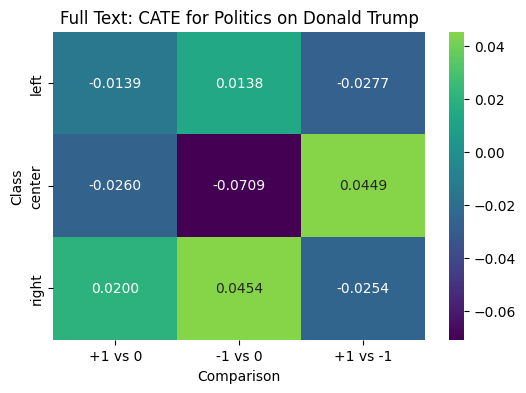

In [92]:
# plot_treatment_effect_heatmap(
#     effect_dict={'sentiment Politics': ate}, 
#     title="50 Word Summary: Treatment Effects of sentiment on Politics", 
#     prefix=f'{type}_p_ate', 
#     cmap="viridis"
# )

plot_treatment_effect_heatmap(
    effect_dict={'sentiment Media Bias': cate}, 
    title="Full Text: CATE for Politics on Donald Trump", 
    prefix=f'{type}_p_dt_cate', 
    cmap="viridis"
)

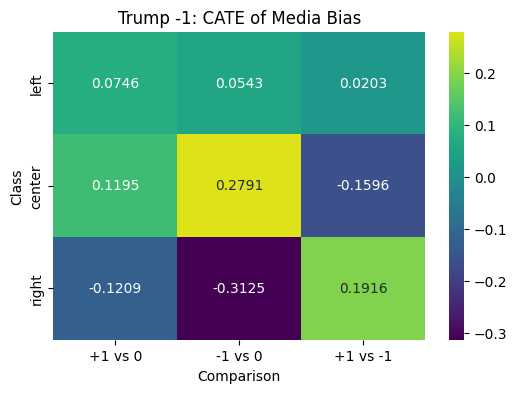

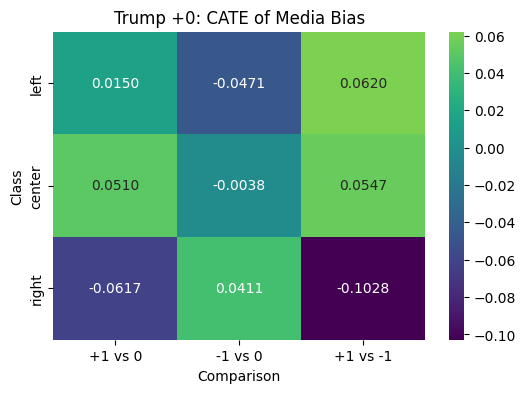

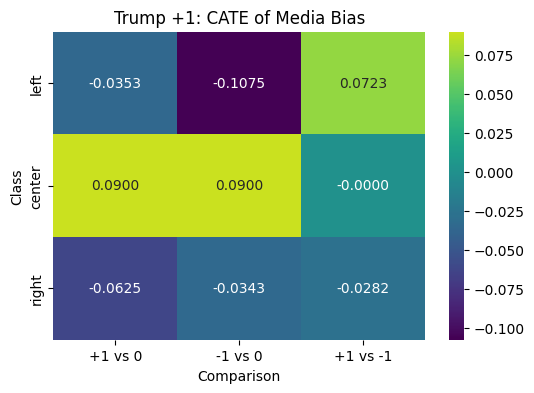

In [69]:
plot_treatment_effect_heatmap(
    effect_dict={'sentiment Media Bias': strat[-1]}, 
    title="Trump -1: CATE of Media Bias", 
    prefix=f'{type}_mb_dt_strat_-1', 
    cmap="viridis"
)
plot_treatment_effect_heatmap(
    effect_dict={'sentiment Media Bias': strat[0]}, 
    title="Trump +0: CATE of Media Bias", 
    prefix=f'{type}_mb_dt_strat_+0', 
    cmap="viridis"
)
plot_treatment_effect_heatmap(
    effect_dict={'sentiment Media Bias': strat[1]}, 
    title="Trump +1: CATE of Media Bias", 
    prefix=f'{type}_mb_dt_strat_+1', 
    cmap="viridis"
)